В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/edce80b5bb02479085855b2334b17fc1). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

**Завдання 0.** Завантаження даних та імпорт бібліотек



In [1]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2'

od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: olgatuka
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 370MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu-course-c-2/bank-customer-churn-prediction-dlu-course-c-2.zip to ./bank-customer-churn-prediction-dlu-course-c-2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import joblib
import warnings

**Завдання 1.** Збираємо весь код в одному місці.

**1.1. Попередня обробка даних, створення пайплайну, тренування моделі**

In [3]:
# Читання даних з файлу
raw_df = pd.read_csv('./bank-customer-churn-prediction-dlu-course-c-2/train.csv', index_col=0)

# Вилучення ознак не релевантних для моделі
col_to_del = ['CustomerId', 'Surname']
raw_df.drop(columns=col_to_del, inplace=True)

# Розбиття даних на тренувальний та валідаційний набори
train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42)
input_cols = list(train_df.columns)[:-1]
target_col = 'Exited'
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

# Виявляємо числові та категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який включає препроцесінг та логістичну регресію
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо модель
model_pipeline.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

**1.2. Передбачення на тренувальних та валідаційних даних, вимір метрік якості моделі, збереження моделі в форматі joblib**

In [4]:
# Функція, щоб передбачати і рахувати метрики

def predict_and_plot_new(model, inputs, targets, name=''):

    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    f1_score_ = f1_score(targets, preds, pos_label=1)

    fig, ax = plt.subplots(1, 3, figsize=(16, 4))
    fig.suptitle('{} dataset'.format(name), fontsize = 16)

    # Confusion matrix
    cf = confusion_matrix(targets, preds, normalize='true')
    cf_ = confusion_matrix(targets, preds)

    # Create custom labels for confusion matrix
    labels_names = ['True Neg','False Pos','False Neg','True Pos']
    labels_counts = ['{0:0.0f}'.format(value) for value in cf_.flatten()]
    labels_percentages = ['{0:.2%}'.format(value) for value in cf.flatten()]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(labels_names, labels_counts, labels_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    # Plot the confusion matrix
    sns.heatmap(cf, ax = ax[0], annot = labels, fmt = '')
    ax[0].set_title('{} Confusion Matrix'.format(name), fontsize = 10)
    ax[0].set_xlabel('Prediction')
    ax[0].set_ylabel('Target')

    # Predict probabilities
    preds_proba = model.predict_proba(inputs)[:, 1]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(targets, preds_proba, pos_label=1)

    # Compute AUROC
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[1].set_title(f'Receiver Operating Characteristic (ROC) Curve for {name}', fontsize = 10)
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])

    # Plot accuracy metrics
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].set_title(f'{name} accuracy metrics', fontsize = 10)
    ax[2].text(0.5, 0.7, f'Accuracy: {accuracy:.4f}', fontsize=12, ha='center')
    ax[2].text(0.5, 0.5, f'F1 score: {f1_score_:.4f}', fontsize=12, ha='center')
    ax[2].text(0.5, 0.3, f'AUROC: {roc_auc:.4f}', fontsize=16, color='darkorange', ha='center')

    plt.show()

    return preds, preds_proba

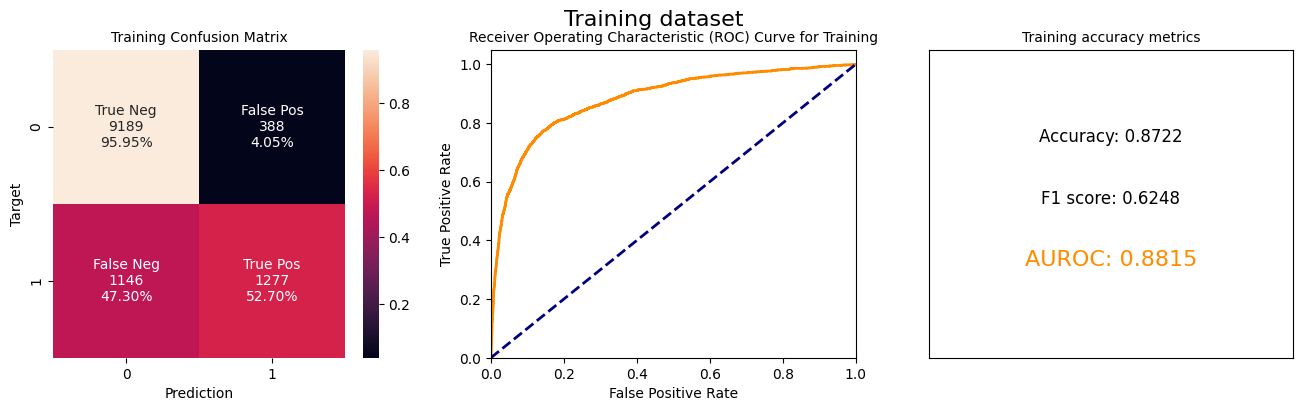

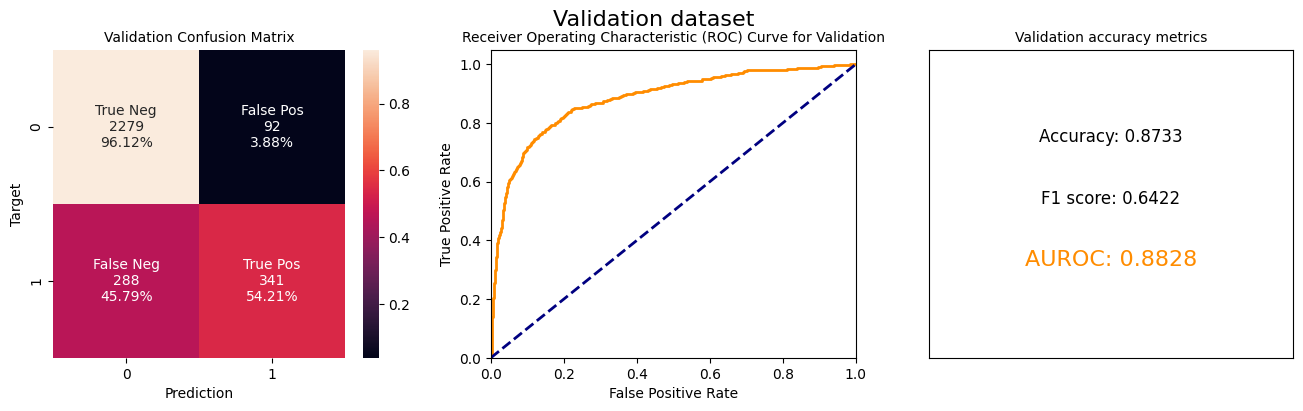

In [5]:
# Оцінюємо модель на тренувальних і валідаційних даних
train_preds, train_preds_proba = predict_and_plot_new(model_pipeline, train_inputs, train_targets, 'Training')
val_preds, val_preds_proba = predict_and_plot_new(model_pipeline, val_inputs, val_targets, 'Validation')

In [6]:
# Зберігаємо модель для подальшого використання

joblib.dump(model_pipeline, './bank-customer-churn-prediction-dlu-course-c-2/customer_churn_model_pipeline.joblib')

['./bank-customer-churn-prediction-dlu-course-c-2/customer_churn_model_pipeline.joblib']

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

In [7]:
import operator
from sklearn.preprocessing import PolynomialFeatures

In [8]:
# Додаємо в попередню обробку числових колонок генерацію polinomal features до степені 2 включно

degree = 2

numeric_transformer_poly = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(degree=degree))
])

# Комбінуємо трансформери в один препроцесор
preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
])

# Стоврюємо пайплайн, який включає препроцесінг та логістичну регресію
model_pipeline_poly2 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо модель
model_pipeline_poly2.fit(train_inputs, train_targets)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly_features',
                                                                   PolynomialFeatures())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

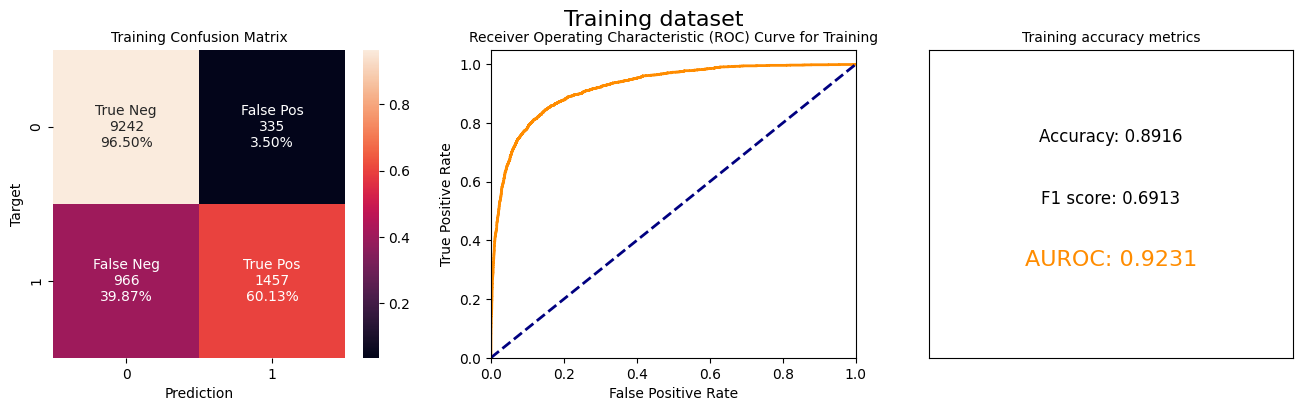

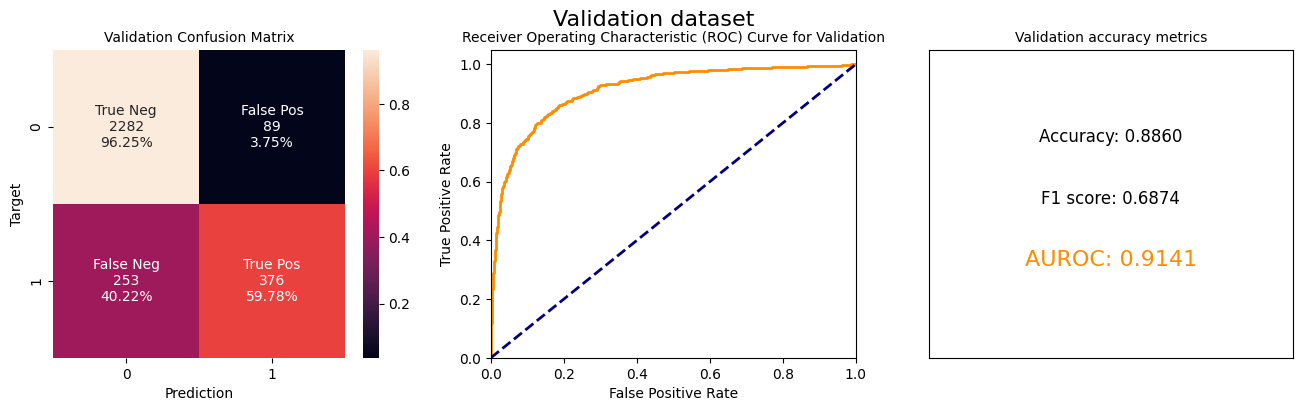

In [9]:
# Оцінюємо модель на тренувальних і валідаційних даних
train_preds, train_preds_proba = predict_and_plot_new(model_pipeline_poly2, train_inputs, train_targets, 'Training')
val_preds, val_preds_proba = predict_and_plot_new(model_pipeline_poly2, val_inputs, val_targets, 'Validation')

**Висновок.** З додаванням поліноміальних ознак якість моделі значно покращилася - показник AUROC виріс приблизно на 0.04 для тренувального набору даних (0.9231), та на 0.03 для валідаційного (0.9141). Різниця між AUROC_train та AUROC_val становить всього 0.009, тобто модель досить добре генералізує.  

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

In [10]:
degree = 4

numeric_transformer_poly = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(degree=degree))
])

# Комбінуємо трансформери в один препроцесор
preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
])

# Стоврюємо пайплайн, який включає препроцесінг та логістичну регресію
model_pipeline_poly4 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо модель
model_pipeline_poly4.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly_features',
                                                                   PolynomialFeatures(degree=4))]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

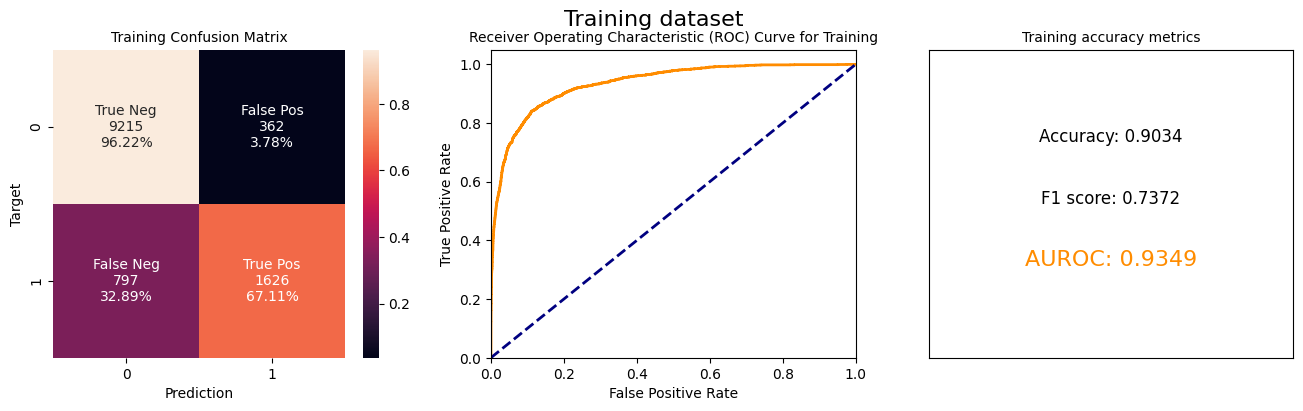

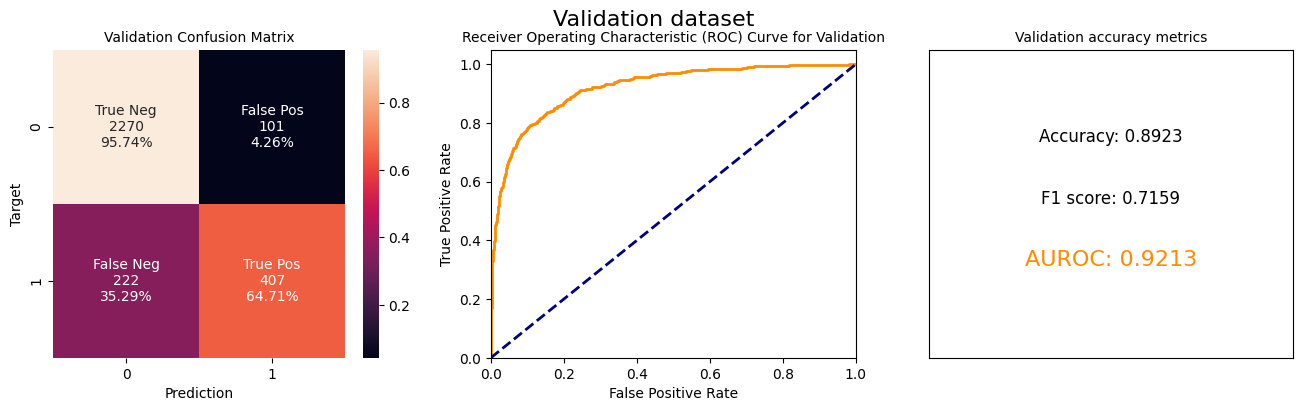

In [11]:
# Оцінюємо модель на тренувальних і валідаційних даних
train_preds, train_preds_proba = predict_and_plot_new(model_pipeline_poly4, train_inputs, train_targets, 'Training')
val_preds, val_preds_proba = predict_and_plot_new(model_pipeline_poly4, val_inputs, val_targets, 'Validation')

**Висновок.** показник AUROC виріс приблизно на 0.012 для тренувального набору даних, та на 0.007 для валідаційного. Різниця між AUROC_train та AUROC_val становить всього 0.014, тобто модель все ще непогано генералізує. Але здається, що покращення показників точності на валідаційному наборі даних починає сповільнюватися порівняно з тренувальним. Можливо при подальшому збільшенні степені полінома модель почне перенавчатися, та точність на валідаційних даних почне погіршуватися. Але порівняно з попередньою моделлю ця все ж виглядає краще (AUROC_train = 0.9349, AUROC_val = 0.9213).

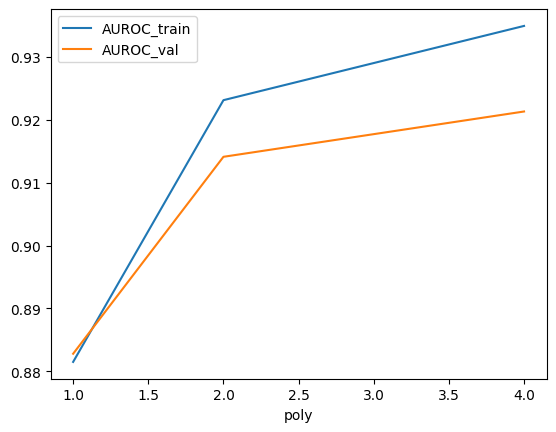

In [12]:
AUROC_train = [0.8815, 0.9231, 0.9349]
AUROC_val = [0.8828, 0.9141, 0.9213]
poly = [1, 2, 4]
df_AUROC = pd.DataFrame({'AUROC_train': AUROC_train, 'AUROC_val': AUROC_val, 'poly': poly})
df_AUROC.plot(x='poly');

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [14]:
df = pd.read_csv('regression_data.csv')
df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_1  129 non-null    float64
 1   feature_2  129 non-null    float64
 2   feature_3  129 non-null    float64
 3   feature_4  129 non-null    float64
 4   feature_5  129 non-null    float64
 5   target     129 non-null    float64
dtypes: float64(6)
memory usage: 6.2 KB


In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [17]:
input_cols = list(df.columns)[:-1]
target_col = 'target'
X = df[input_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((103, 5), (26, 5))

In [18]:
model_pipeline_poly5 = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=5)),
    ('estimator', LinearRegression())
])

model_pipeline_poly5.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(degree=5)),
                ('estimator', LinearRegression())])

In [19]:
# Оцінюємо модель на тренувальних і тестувальних даних

from sklearn.metrics import root_mean_squared_error

y_train_pred = model_pipeline_poly5.predict(X_train)
y_test_pred = model_pipeline_poly5.predict(X_test)

rmse_train = round(root_mean_squared_error(y_train, y_train_pred),5)
rmse_test = round(root_mean_squared_error(y_test, y_test_pred),5)

print(f'RMSE (train dataset): {rmse_train}')
print(f'RMSE (test dataset): {rmse_test}')

print(f'Model R^2 score (train dataset): {round(model_pipeline_poly5.score(X_train, y_train),5)}')
print(f'Model R^2 score (test dataset): {round(model_pipeline_poly5.score(X_test, y_test),5)}')

RMSE (train dataset): 0.0
RMSE (test dataset): 35.62805
Model R^2 score (train dataset): 1.0
Model R^2 score (test dataset): 0.45593


**Висновок.** Ми бачимо, що для тренувального набору даних RMSE = 0 та R^2 = 1. Це свідчить про те, що модель заоферфітилась і просто запам'ятала тренувальні дані, тому не зможе добре генералізувати. Що й помітно з показників точності для тестового набору. Тобто нам потрібно спростити нашу модель або спробувати використати методи регуляризації.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [20]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet()
]

In [21]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_metrics = round(root_mean_squared_error(y_train, y_train_pred),5)
    test_metrics = round(root_mean_squared_error(y_test, y_test_pred),5)

    return dict(train=train_metrics, test=test_metrics)

In [22]:
warnings.filterwarnings("ignore")

for estimator in models:
    model_pipeline = Pipeline(steps=[
      ('scaler', StandardScaler()),
      ('poly', PolynomialFeatures(degree=20)),
      ('estimator', estimator)
    ])
    model_pipeline.fit(X_train, y_train)
    eval_results = evaluate_model(model_pipeline, X_train, y_train, X_test, y_test)
    print(f'{str(estimator)} RMSE: {eval_results}\n')

LinearRegression() RMSE: {'train': 1.00812, 'test': 31605765.90502}

Ridge() RMSE: {'train': 30.87912, 'test': 152443.03159}

Lasso() RMSE: {'train': 2.19752, 'test': 14.94498}

ElasticNet() RMSE: {'train': 9.14766, 'test': 241.66386}



Найкращий результат показує модель з регуляризацією **Lasso**:
- маємо достатньо низький RMSE на тренувальному наборі та найнижче значення RMSE для тестових даних
- щодо генералізації, то ця модель генералізує набагато краще в порівнянні з іншими моделями в нашому експерименті (найнижчий показник RMSE на тестовому наборі та найменша різниця між похибками на тренувальному та тестовому наборах), але абсолютне співвідношення RMSE test vs. RMSE train все ще не виглядає оптимальним.

Моделі **Ridge** та **ElasticNet** мають значно більші похибки на тренувальному наборі, а якщо подивитися на похибки на тестових даних, то можна зробити висновок, що обидві ці моделі погано генералізують.

Для того, щоб зрозуміти, чому регуляризація Lasso спрацювала краще за інші, проведемо додатковий аналіз ознак та вагів.
Можна зробити припущення, що ця модель не заоверфітилась як приміром звичайна лінійна регресія, тому що має таку властивість як зменшення вагів для менш значущих ознак і може використовуватися для відбору ознак (feature selection).

In [23]:
model = models[2]
model

Lasso()

In [24]:
poly_step = model_pipeline.named_steps['poly']
poly_step

PolynomialFeatures(degree=20)

In [25]:
coefs_df = pd.DataFrame(poly_step.get_feature_names_out(X_train.columns), columns=['feature_name'])
coefs_df['value'] = model.coef_.round(5).flatten()

In [26]:
coefs_df.set_index('feature_name').sort_values(by='value', ascending=False).iloc[:10].style.background_gradient()

,value
feature_name,
feature_4,38.949950
feature_4^5,0.638780
feature_4 feature_5^8,0.027400
feature_2^6 feature_4,0.008280
feature_1^6 feature_4^7,0.007490
feature_1^4 feature_3^9,0.005610
feature_4 feature_5^10,0.004840
feature_1 feature_3 feature_4^9,0.004230
feature_4 feature_5^11,0.003390


Модель з регуляризацією Lasso зменшила коефіцієнти для всіх ознак крім **feature_4**. Проведемо додатковий аналіз даних, щоб зрозуміти взаємозалежності між ознаками та цільовою змінною. Скористаємося простими коефіцієнтами кореляції та графіком pairplot.

In [27]:
df.corr().style.background_gradient()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
feature_1,1.000000,0.090286,0.068160,0.005709,0.112917,0.007453
feature_2,0.090286,1.000000,-0.031918,-0.050098,0.075303,-0.049995
feature_3,0.068160,-0.031918,1.000000,-0.043707,0.016758,-0.042851
feature_4,0.005709,-0.050098,-0.043707,1.000000,-0.151899,0.999734
feature_5,0.112917,0.075303,0.016758,-0.151899,1.000000,-0.155143
target,0.007453,-0.049995,-0.042851,0.999734,-0.155143,1.000000


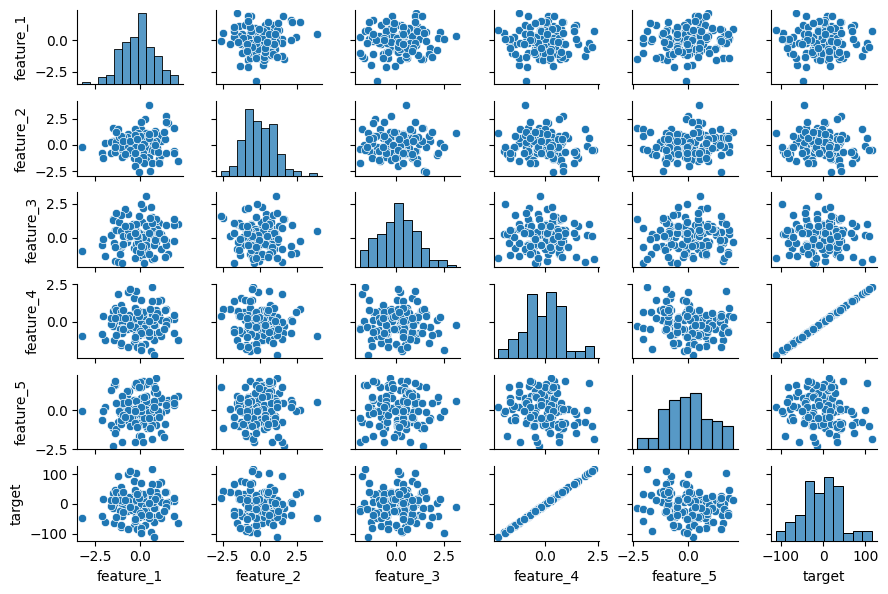

In [28]:
sns.pairplot(df, height = 1, aspect = 1.5);

З коефіцієнтів кореляції та графиків pairplot можна зробити висновок, що тільки ознака **feature_4** має чіткий взаємозв'язок з цільовою змінною, і це лінійна залежність.
Спробуємо натренувати просту модель лінійної регресії за однією ознакою (**feature_4**).

In [29]:
model_linreg = LinearRegression()
X_train_f4 = X_train['feature_4'].to_frame()
X_test_f4 = X_test['feature_4'].to_frame()

model_linreg.fit(X_train_f4, y_train)
y_train_pred_f4 = model_linreg.predict(X_train_f4)
y_test_pred_f4 = model_linreg.predict(X_test_f4)
rmse_train_f4 = round(root_mean_squared_error(y_train, y_train_pred_f4),5)
rmse_test_f4 = round(root_mean_squared_error(y_test, y_test_pred_f4),5)
print(f'RMSE of LinReg model based only on feature 4 (train dataset): \t{rmse_train_f4}')
print(f'RMSE of LinReg model based only on feature 4 (test dataset): \t{rmse_test_f4}')
print(f'LinReg model R^2 score (train dataset): {round(model_linreg.score(X_train_f4, y_train),5)}')
print(f'LinReg model R^2 score (test dataset): {round(model_linreg.score(X_test_f4, y_test),5)}')

RMSE of LinReg model based only on feature 4 (train dataset): 	1.0902
RMSE of LinReg model based only on feature 4 (test dataset): 	0.85205
LinReg model R^2 score (train dataset): 0.99939
LinReg model R^2 score (test dataset): 0.99969


**Висновок.** Як ми бачимо, для нашого набору даних проста модель лінійної регресії за однією (але правильно обраною) ознакою показала найвищу точність, кращий результат ніж всі більш складні моделі з поліноміальними ознаками та різними методами регуляризації. Тобто якісно і вчасно проведений EDA може значно спростити вимоги до моделі та скоротити час на її побудову та тренування.